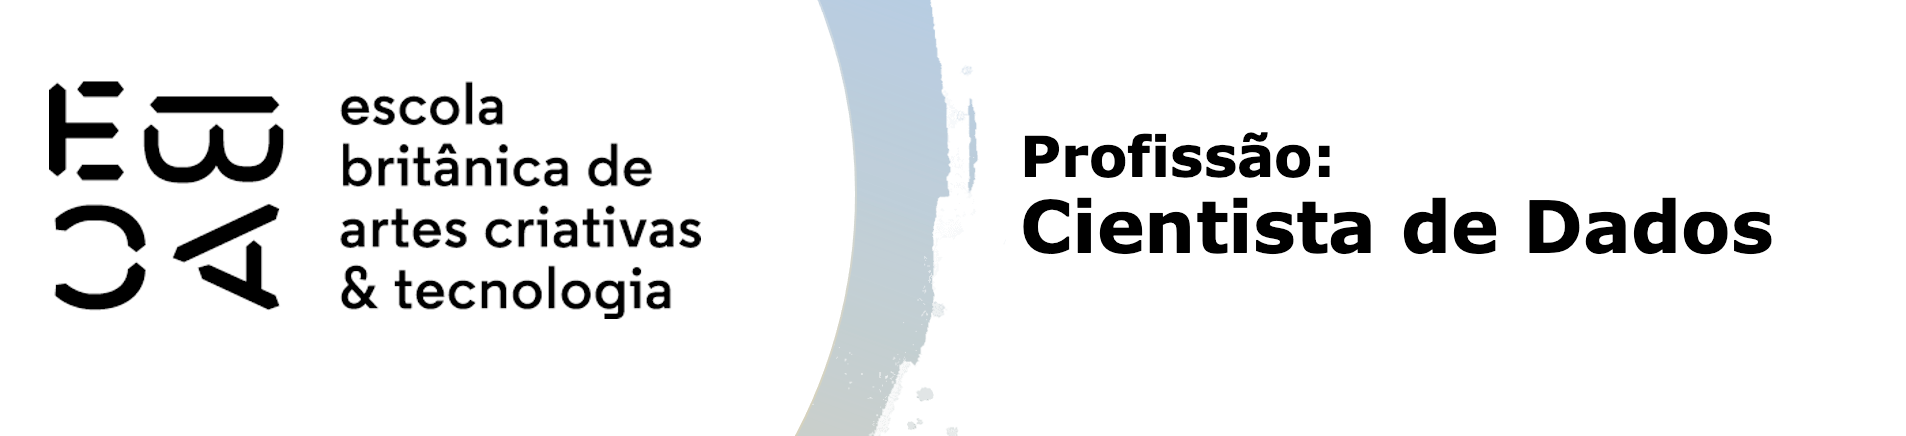

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [174]:
data = pd.read_feather('credit_scoring.ftr')
data['mau'] = data.mau.astype('int64')
data = data.sample(50000)

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [175]:
df_oot = data.copy().query("data_ref >= '2016-01-01'")
df = data.copy().query("data_ref < '2016-01-01'")

variaveis = ['sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau']


In [176]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [177]:
metadados = pd.DataFrame(df[variaveis].dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'

for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0.0,2.0,covariavel,0.000115
posse_de_veiculo,object,0.0,2.0,covariavel,0.000025
posse_de_imovel,object,0.0,2.0,covariavel,0.008643
qtd_filhos,int64,0.0,8.0,covariavel,0.000018
tipo_renda,object,0.0,5.0,covariavel,inf
educacao,object,0.0,5.0,covariavel,0.005671
estado_civil,object,0.0,5.0,covariavel,0.004123
tipo_residencia,object,0.0,6.0,covariavel,0.012035
idade,int64,0.0,47.0,covariavel,0.014767
tempo_emprego,float64,6794.0,2942.0,covariavel,0.390891


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [178]:
df.groupby('data_ref').count()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
data_ref,,,,,,,,,,,,,,
2015-01-01,3229,3229,3229,3229,3229,3229,3229,3229,3229,3229,2682,3229,3229,3229
2015-02-01,3394,3394,3394,3394,3394,3394,3394,3394,3394,3394,2812,3394,3394,3394
2015-03-01,3412,3412,3412,3412,3412,3412,3412,3412,3412,3412,2820,3412,3412,3412
2015-04-01,3272,3272,3272,3272,3272,3272,3272,3272,3272,3272,2764,3272,3272,3272
2015-05-01,3335,3335,3335,3335,3335,3335,3335,3335,3335,3335,2773,3335,3335,3335
2015-06-01,3326,3326,3326,3326,3326,3326,3326,3326,3326,3326,2758,3326,3326,3326
2015-07-01,3290,3290,3290,3290,3290,3290,3290,3290,3290,3290,2667,3290,3290,3290
2015-08-01,3257,3257,3257,3257,3257,3257,3257,3257,3257,3257,2704,3257,3257,3257
2015-09-01,3370,3370,3370,3370,3370,3370,3370,3370,3370,3370,2781,3370,3370,3370


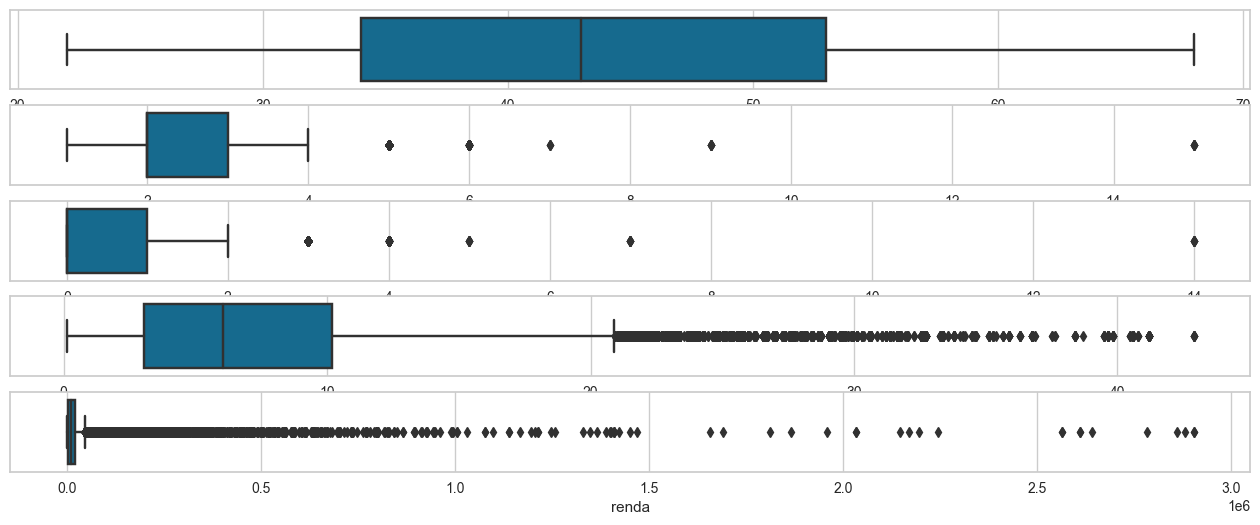

In [179]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(16, 6))
continuas = ['idade', 'qt_pessoas_residencia', 'qtd_filhos', 'tempo_emprego', 'renda']
for i, var in enumerate(continuas):
    sns.boxplot(ax=axes[i], x=df[var])

<AxesSubplot: xlabel='renda'>

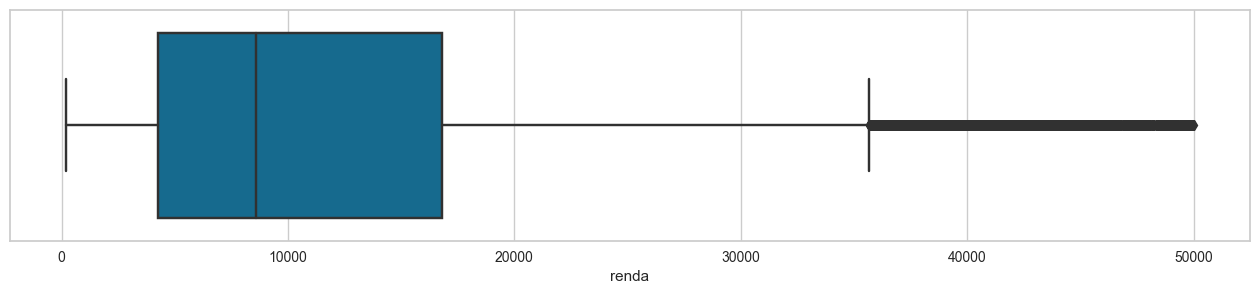

In [180]:
df = df.query('renda < 50000')
df_oot = df_oot.query('renda < 50000')

fig, ax = plt.subplots(figsize=(16, 3))
sns.boxplot(ax=ax, x=df['renda'])

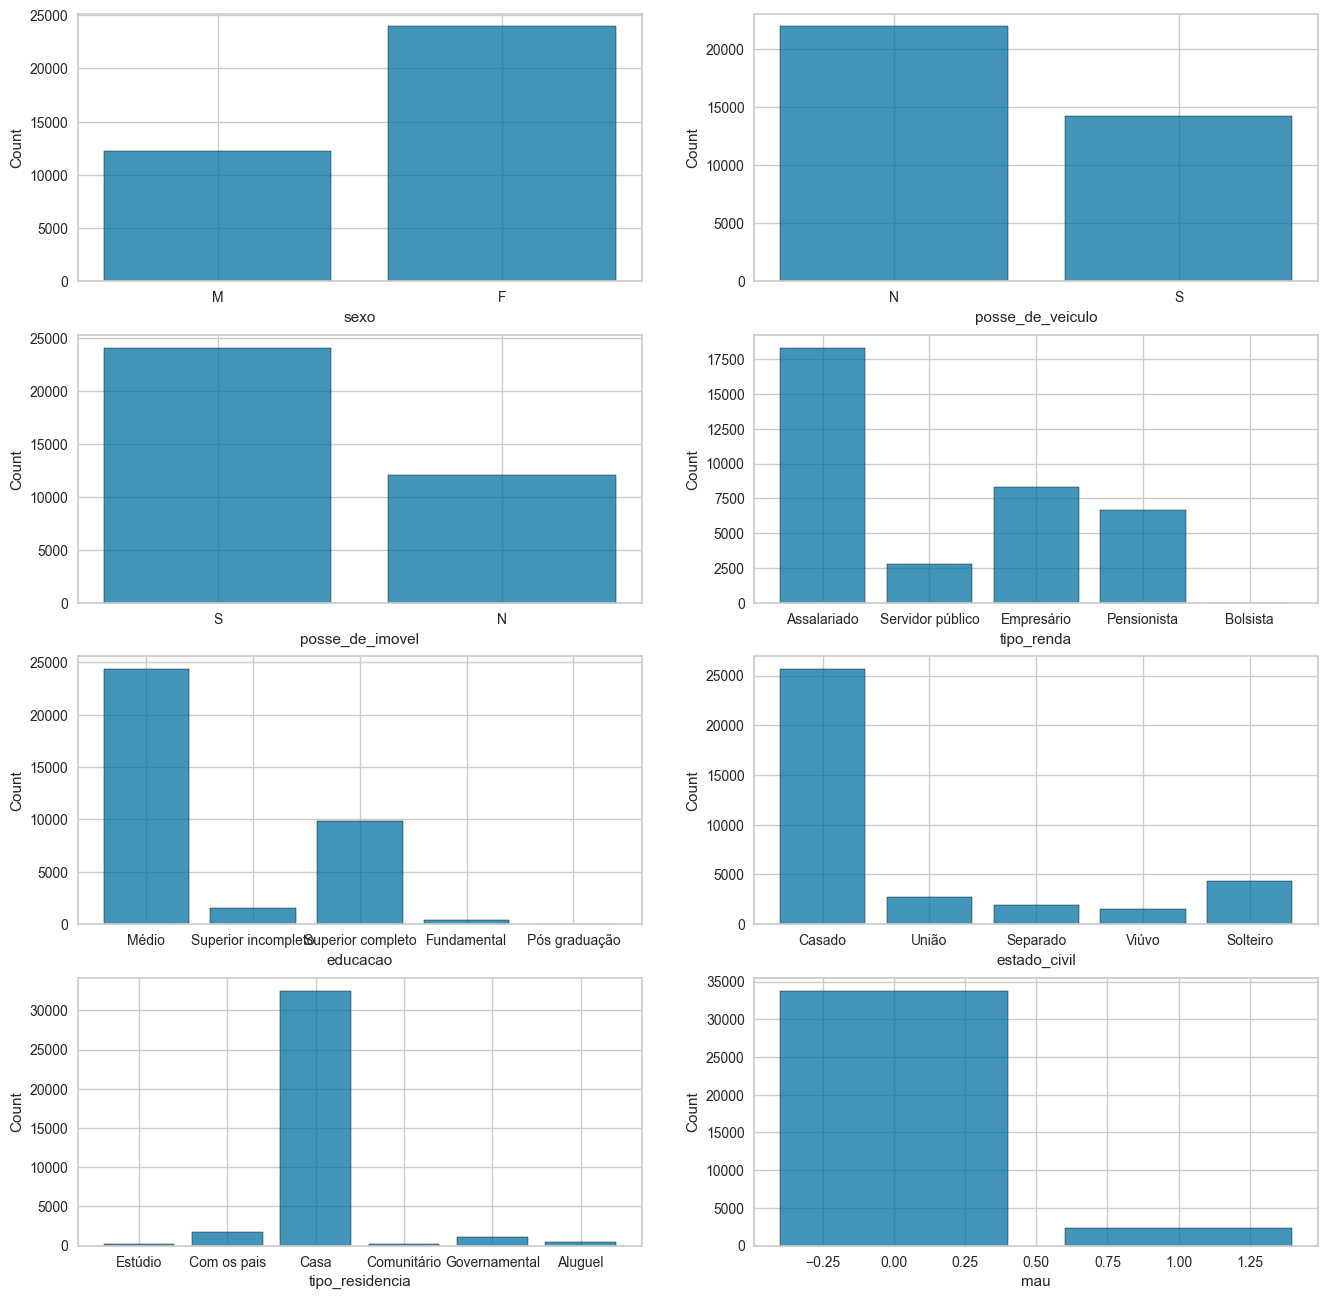

In [181]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))
discretas = [var for var in variaveis if var not in continuas]


for i, var in enumerate(discretas):
    sns.histplot(ax=axes[i//2][i%2], x=df[var], binwidth=.5, discrete=True, shrink=.8)

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [182]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    
    return display(biv)


def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return display(biv)


,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,22331,1618,0.06756,F,23949,0.001622,0.070739,0.064381,-2.624785,-2.575390,-2.676385,0.026200,0.075595,-0.025400
M,11488,769,0.06274,M,12257,0.002190,0.067033,0.058446,-2.703967,-2.633184,-2.779424,-0.052982,0.017801,-0.128438


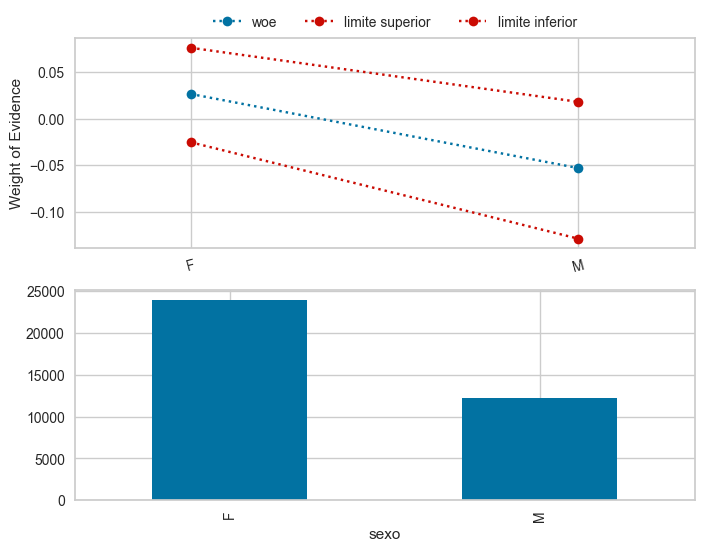

In [183]:
biv_discreta(discretas[0], df);

,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,20510,1455,0.066242,N,21965,0.001678,0.069531,0.062953,-2.645907,-2.593917,-2.700353,0.005079,0.057068,-0.049367
S,13309,932,0.065445,S,14241,0.002072,0.069507,0.061383,-2.658863,-2.594287,-2.727280,-0.007878,0.056698,-0.076294


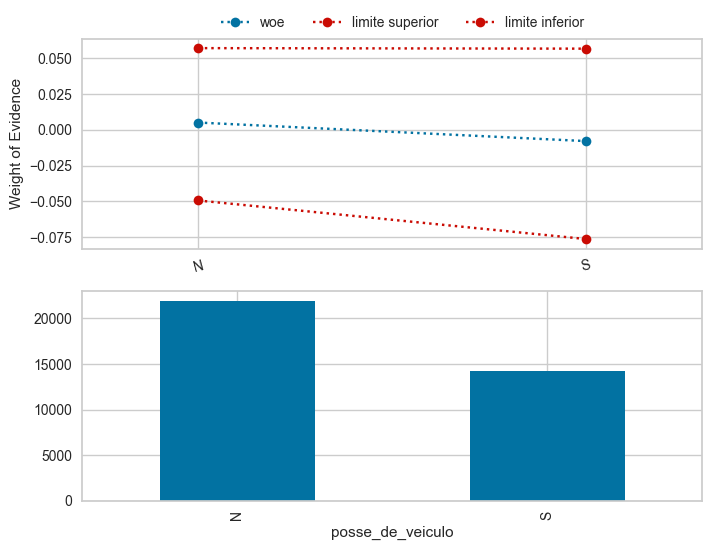

In [184]:
biv_discreta(discretas[1], df);

,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,11199,886,0.073314,N,12085,0.002371,0.077962,0.068666,-2.536863,-2.470370,-2.607357,0.114123,0.180615,0.043628
S,22620,1501,0.062228,S,24121,0.001555,0.065277,0.059179,-2.712703,-2.661617,-2.766182,-0.061717,-0.010631,-0.115196


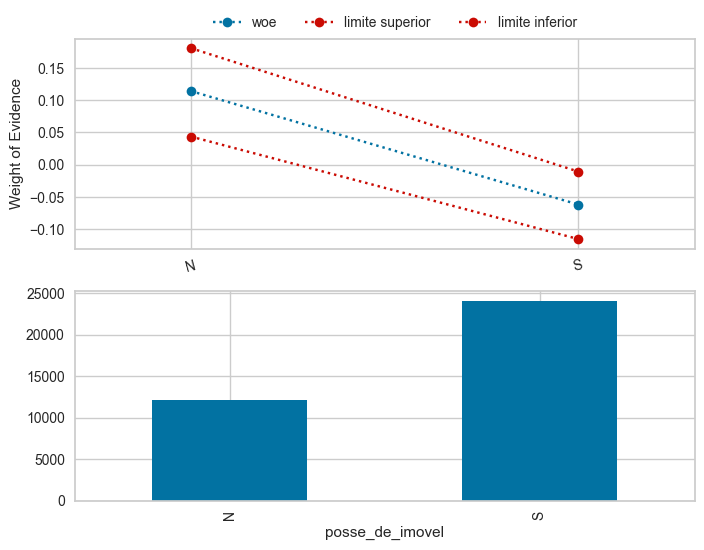

In [185]:
biv_discreta(discretas[2], df);

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,17017,1308,0.071378,Assalariado,18325,0.001902,0.075106,0.067650,-2.565714,-2.510783,-2.623360,0.085272,0.140203,0.027626
Bolsista,20,0,0.000000,Bolsista,20,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
Empresário,7829,513,0.061496,Empresário,8342,0.002630,0.066652,0.056340,-2.725314,-2.639291,-2.818361,-0.074329,0.011694,-0.167376
Pensionista,6268,429,0.064059,Pensionista,6697,0.002992,0.069924,0.058193,-2.681756,-2.587858,-2.784033,-0.030770,0.063127,-0.133048
Servidor público,2685,137,0.048547,Servidor público,2822,0.004046,0.056480,0.040614,-2.975455,-2.815731,-3.162174,-0.324470,-0.164745,-0.511189


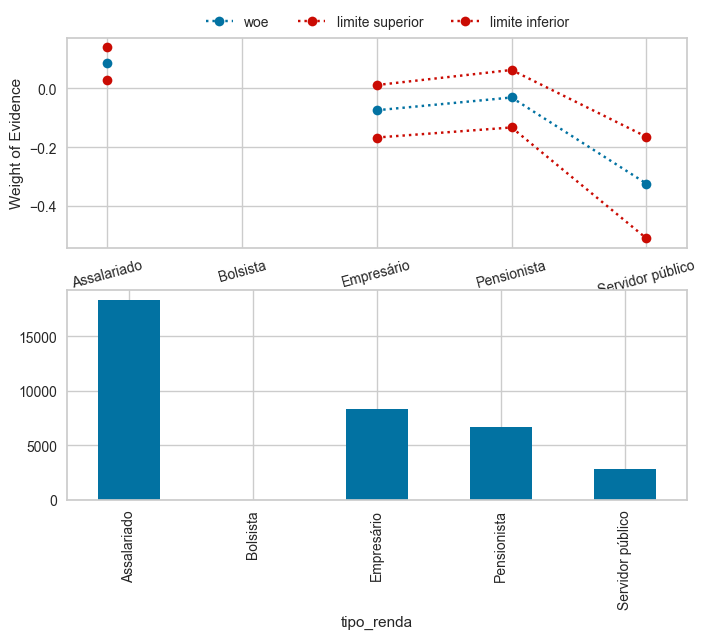

In [186]:
biv_discreta(discretas[3], df);

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado/Bolsista,17037,1308,0.071300,Assalariado/Bolsista,18345,0.001900,0.075024,0.067576,-2.566888,-2.511960,-2.624532,0.084097,0.139026,0.026453
Empresário,7829,513,0.061496,Empresário,8342,0.002630,0.066652,0.056340,-2.725314,-2.639291,-2.818361,-0.074329,0.011694,-0.167376
Pensionista,6268,429,0.064059,Pensionista,6697,0.002992,0.069924,0.058193,-2.681756,-2.587858,-2.784033,-0.030770,0.063127,-0.133048
Servidor público,2685,137,0.048547,Servidor público,2822,0.004046,0.056480,0.040614,-2.975455,-2.815731,-3.162174,-0.324470,-0.164745,-0.511189


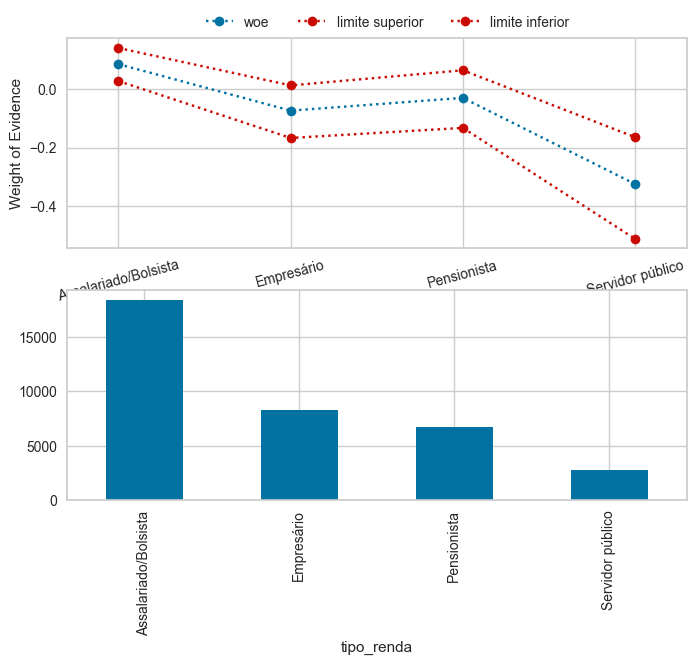

In [187]:
df2 = df.copy()
df_oot2 = df_oot.copy()
df2.tipo_renda.replace({'Assalariado': 'Assalariado/Bolsista', 'Bolsista': 'Assalariado/Bolsista'}, inplace=True)
df_oot2.tipo_renda.replace({'Assalariado': 'Assalariado/Bolsista', 'Bolsista': 'Assalariado/Bolsista'}, inplace=True)
biv_discreta('tipo_renda', df2)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,403,31,0.071429,Fundamental,434,0.012362,0.095726,0.047131,-2.564949,-2.245641,-3.006546,0.086036,0.405344,-0.355561
Médio,22696,1667,0.068423,Médio,24363,0.001618,0.071594,0.065253,-2.611163,-2.562460,-2.662004,0.039822,0.088525,-0.011018
Pós graduação,41,5,0.108696,Pós graduação,46,0.045892,0.201128,0.016264,-2.104134,-1.379262,-4.102420,0.546851,1.271724,-1.451434
Superior completo,9280,584,0.059205,Superior completo,9864,0.002376,0.063863,0.054547,-2.765716,-2.685018,-2.852598,-0.114730,-0.034033,-0.201613
Superior incompleto,1399,100,0.066711,Superior incompleto,1499,0.006445,0.079353,0.054069,-2.638343,-2.451173,-2.861900,0.012643,0.199813,-0.210915


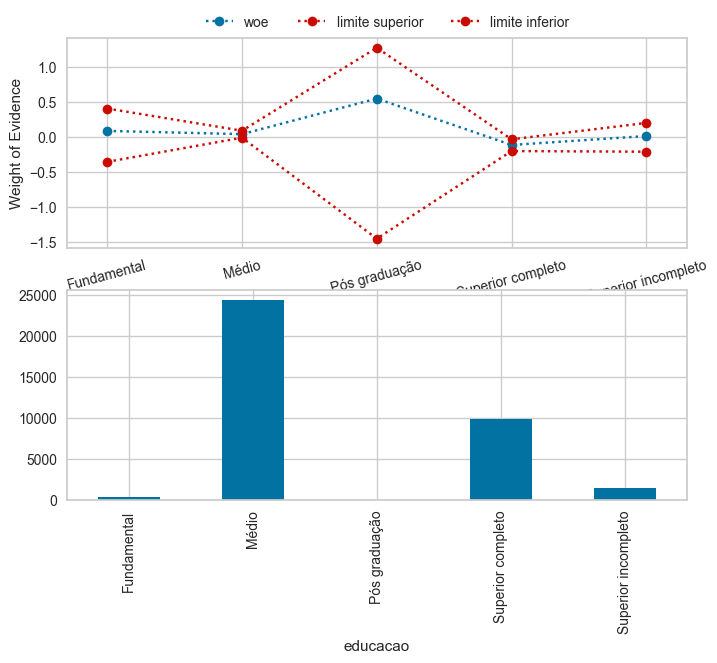

In [188]:
biv_discreta(discretas[4], df);

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental/Médio,23099,1698,0.068476,Fundamental/Médio,24797,0.001604,0.071620,0.065332,-2.610338,-2.562071,-2.660703,0.040647,0.088914,-0.009718
Superior,10720,689,0.060391,Superior,11409,0.002230,0.064762,0.056019,-2.744625,-2.670075,-2.824407,-0.093640,-0.019090,-0.173422


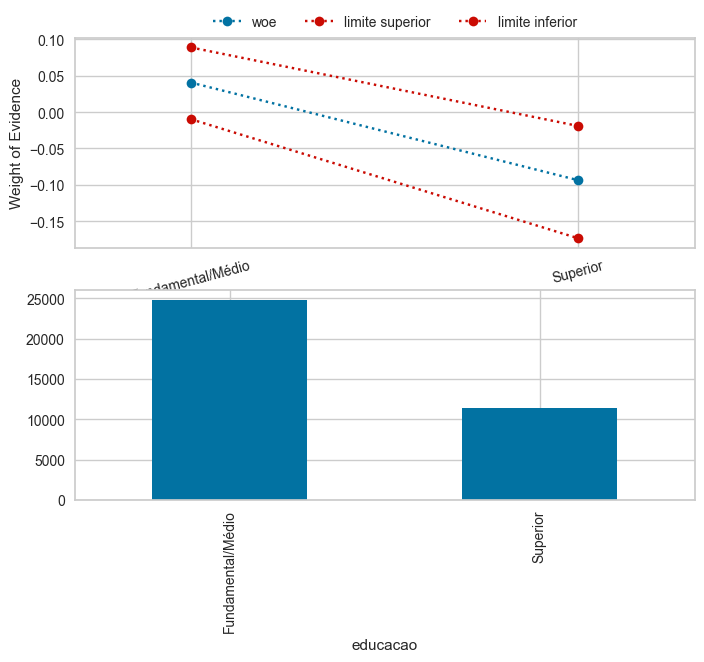

In [189]:
df2.educacao.replace({'Fundamental': 'Fundamental/Médio', 'Médio': 'Fundamental/Médio'}, inplace=True)
df2.educacao.replace({'Pós graduação': 'Superior', 'Superior completo': 'Superior', 'Superior incompleto': 'Superior'}, inplace=True)
df_oot2.educacao.replace({'Fundamental': 'Fundamental/Médio', 'Médio': 'Fundamental/Médio'}, inplace=True)
df_oot2.educacao.replace({'Pós graduação': 'Superior', 'Superior completo': 'Superior', 'Superior incompleto': 'Superior'}, inplace=True)
biv_discreta('educacao', df2)

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,23993,1658,0.064637,Casado,25651,0.001535,0.067646,0.061628,-2.672150,-2.623424,-2.723036,-0.021165,0.027561,-0.072050
Separado,1814,160,0.081054,Separado,1974,0.006143,0.093101,0.069007,-2.428116,-2.276352,-2.602046,0.222870,0.374634,0.048940
Solteiro,4096,278,0.063557,Solteiro,4374,0.003689,0.070789,0.056325,-2.690145,-2.574628,-2.818634,-0.039160,0.076358,-0.167649
União,2526,202,0.074047,União,2728,0.005013,0.083877,0.064217,-2.526125,-2.390796,-2.679122,0.124861,0.260189,-0.028136
Viúvo,1390,89,0.060176,Viúvo,1479,0.006184,0.072306,0.048046,-2.748423,-2.551801,-2.986358,-0.097437,0.099185,-0.335373


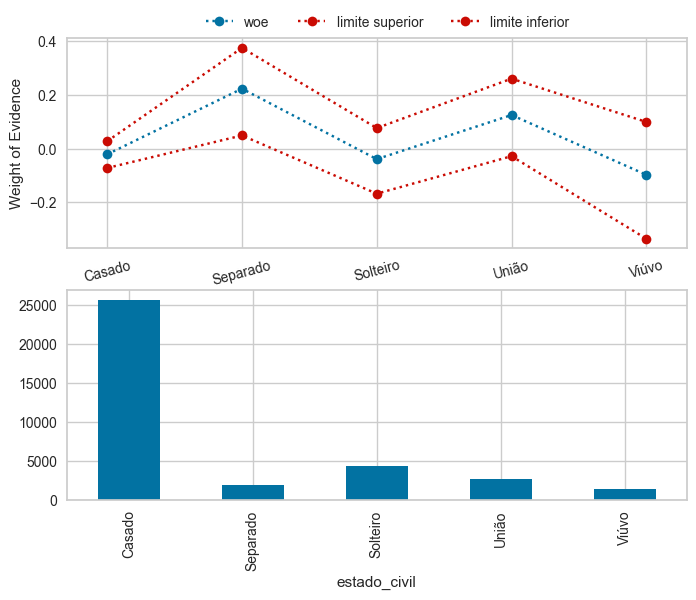

In [190]:
biv_discreta(discretas[5], df);

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,488,32,0.061538,Aluguel,520,0.010539,0.082242,0.040835,-2.724580,-2.412269,-3.156522,-0.073594,0.238716,-0.505537
Casa,30447,2091,0.064263,Casa,32538,0.001359,0.066928,0.061599,-2.678345,-2.634867,-2.723536,-0.027360,0.016119,-0.072551
Com os pais,1547,158,0.092669,Com os pais,1705,0.007022,0.106442,0.078895,-2.281478,-2.127610,-2.457454,0.369508,0.523376,0.193531
Comunitário,138,14,0.092105,Comunitário,152,0.023455,0.138448,0.045763,-2.288196,-1.828241,-3.037445,0.362789,0.822744,-0.386460
Estúdio,229,12,0.049793,Estúdio,241,0.014011,0.077394,0.022191,-2.948815,-2.478298,-3.785608,-0.297830,0.172687,-1.134622
Governamental,970,80,0.076190,Governamental,1050,0.008187,0.092256,0.060125,-2.495269,-2.286394,-2.749323,0.155716,0.364591,-0.098338


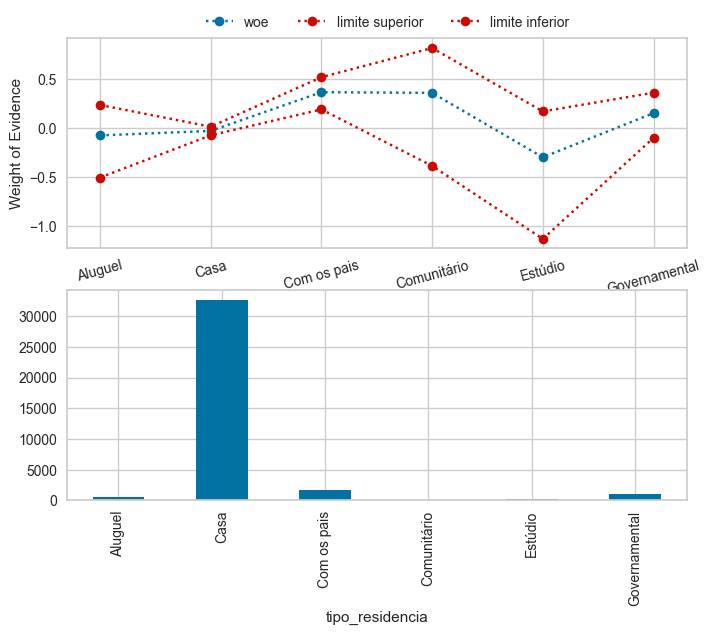

In [191]:
biv_discreta(discretas[6], df);

,qt_bom,qt_mau,mau,idade,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
idade,,,,,,,,,,,,,,
"(21.0, 32.0]",7137,576,0.074679,28.779723,7713,0.002993,0.080547,0.068812,-2.516940,-2.434944,-2.605088,0.134045,0.216042,0.045897
"(32.0, 39.0]",7090,483,0.063779,36.032616,7573,0.002808,0.069284,0.058275,-2.686424,-2.597746,-2.782544,-0.035439,0.053240,-0.131559
"(39.0, 46.0]",6489,459,0.066062,42.841681,6948,0.002980,0.071904,0.060221,-2.648814,-2.557807,-2.747630,0.002172,0.093178,-0.096645
"(46.0, 55.0]",6429,432,0.062965,50.821455,6861,0.002932,0.068713,0.057216,-2.700149,-2.606627,-2.802003,-0.049163,0.044358,-0.151017
"(55.0, 68.0]",6674,437,0.061454,60.496836,7111,0.002848,0.067037,0.055871,-2.726041,-2.633121,-2.827214,-0.075056,0.017864,-0.176228


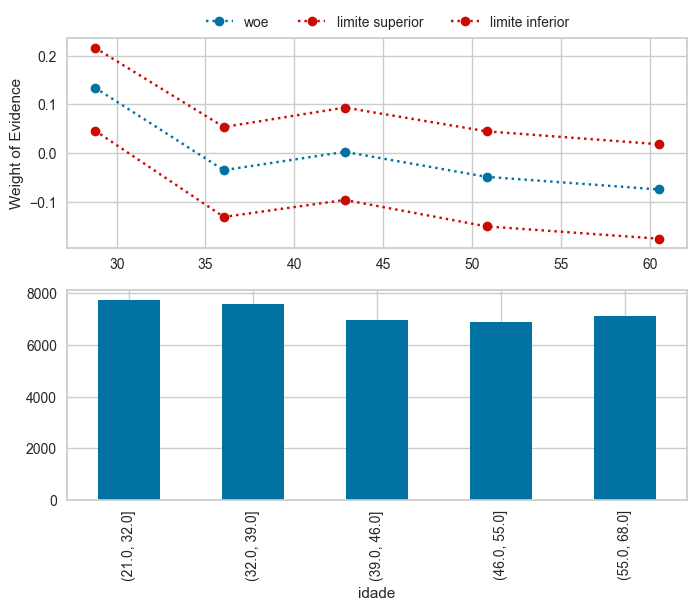

In [192]:
biv_continua(continuas[0], 5, df);

,qt_bom,qt_mau,mau,qt_pessoas_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qt_pessoas_residencia,,,,,,,,,,,,,,
"(0.0, 2.0]",24115,1695,0.065672,1.751182,25810,0.001542,0.068694,0.062650,-2.655151,-2.606920,-2.705492,-0.004166,0.044065,-0.054506
"(2.0, 3.0]",6119,453,0.068929,3.000000,6572,0.003125,0.075055,0.062803,-2.603262,-2.511517,-2.702893,0.047724,0.139468,-0.051907
"(3.0, 4.0]",3110,200,0.060423,4.000000,3310,0.004141,0.068543,0.052303,-2.744061,-2.609288,-2.896983,-0.093075,0.041697,-0.245998
"(4.0, 15.0]",475,39,0.075875,5.297665,514,0.011680,0.098822,0.052929,-2.499753,-2.210388,-2.884414,0.151232,0.440598,-0.233429


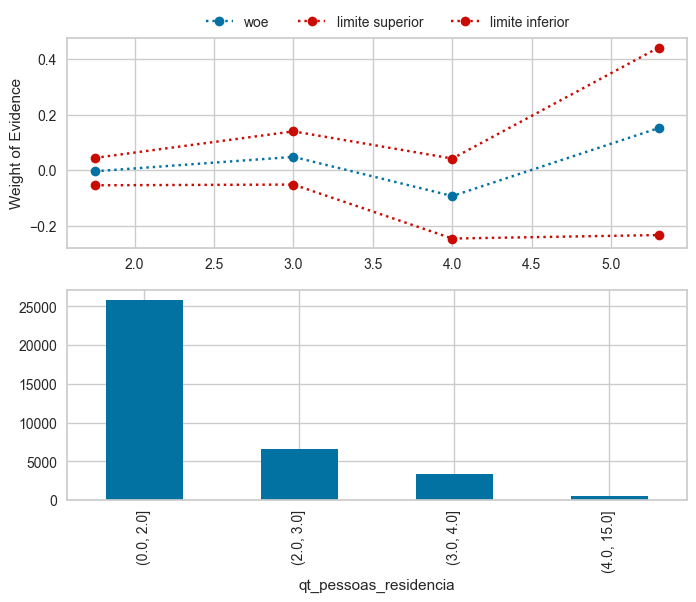

In [193]:
biv_continua(continuas[1], 12, df);

,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
"(-1.0, 1.0]",30095,2132,0.066156,0.237006,32227,0.001385,0.068869,0.063442,-2.647299,-2.604186,-2.692087,0.003687,0.046799,-0.041101
"(1.0, 2.0]",3237,215,0.062283,2.000000,3452,0.004113,0.070347,0.054218,-2.711764,-2.581366,-2.858997,-0.060779,0.069620,-0.208012
"(2.0, 14.0]",487,40,0.075901,3.307400,527,0.011537,0.098565,0.053238,-2.499385,-2.213274,-2.878279,0.151601,0.437712,-0.227293


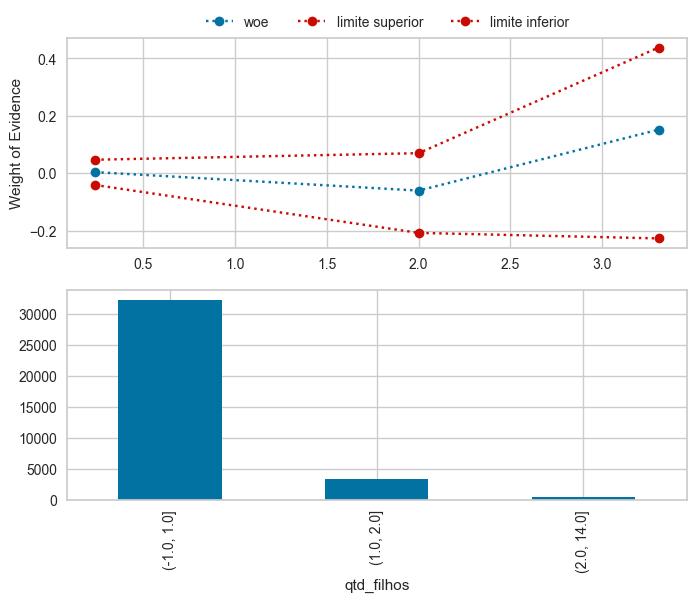

In [194]:
biv_continua(continuas[2], 10, df);

,qt_bom,qt_mau,mau,tempo_emprego,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tempo_emprego,,,,,,,,,,,,,,
"(-1.0, 2.0]",5300,608,0.102911,1.120088,5908,0.003953,0.110661,0.095162,-2.165287,-2.084010,-2.252176,0.485698,0.566975,0.398810
"(2.0, 4.0]",5439,468,0.079228,3.230468,5907,0.003514,0.086117,0.072339,-2.452882,-2.361993,-2.551306,0.198103,0.288993,0.099680
"(4.0, 7.0]",5491,418,0.070740,5.352990,5909,0.003335,0.077278,0.064201,-2.575384,-2.479918,-2.679382,0.075601,0.171068,-0.028396
"(7.0, 10.0]",5595,304,0.051534,7.980753,5899,0.002879,0.057177,0.045891,-2.912601,-2.802725,-3.034504,-0.261615,-0.151739,-0.383519
"(10.0, 37.0]",5744,161,0.027265,13.818214,5905,0.002119,0.031420,0.023110,-3.574507,-3.428399,-3.744089,-0.923521,-0.777414,-1.093103


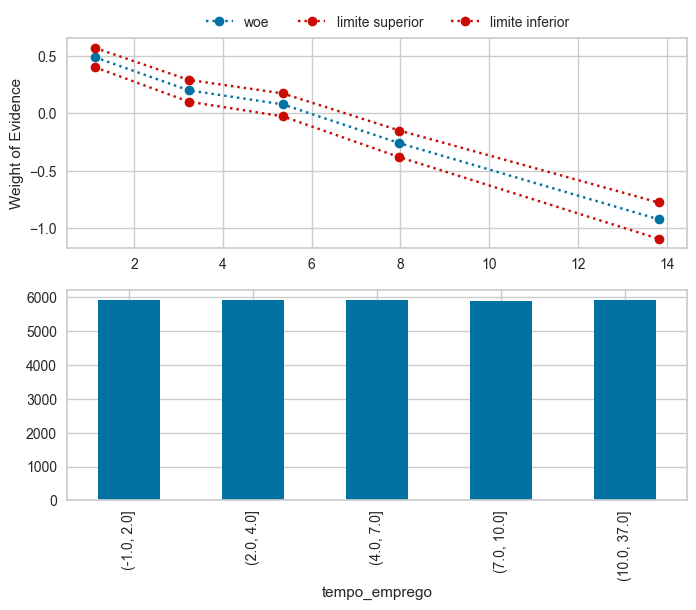

In [195]:
biv_continua(continuas[3], 5, df);

,qt_bom,qt_mau,mau,renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
renda,,,,,,,,,,,,,,
"(213.0, 3595.0]",6036,1206,0.166529,2261.890006,7242,0.004378,0.175110,0.157947,-1.610432,-1.549833,-1.673585,1.040553,1.101153,0.977400
"(3595.0, 6639.0]",6701,541,0.074703,5027.394183,7242,0.003089,0.080759,0.068647,-2.516593,-2.432074,-2.607662,0.134393,0.218911,0.043323
"(6639.0, 11142.0]",6896,345,0.047645,8713.564038,7241,0.002503,0.052553,0.042738,-2.995152,-2.891958,-3.108984,-0.344167,-0.240973,-0.457999
"(11142.0, 19622.0]",7036,204,0.028177,14842.165204,7240,0.001945,0.031989,0.024364,-3.540675,-3.409847,-3.689963,-0.889690,-0.758862,-1.038978
"(19622.0, 49993.0]",7150,91,0.012567,30319.766346,7241,0.001309,0.015134,0.010001,-4.364008,-4.175591,-4.595010,-1.713023,-1.524606,-1.944024


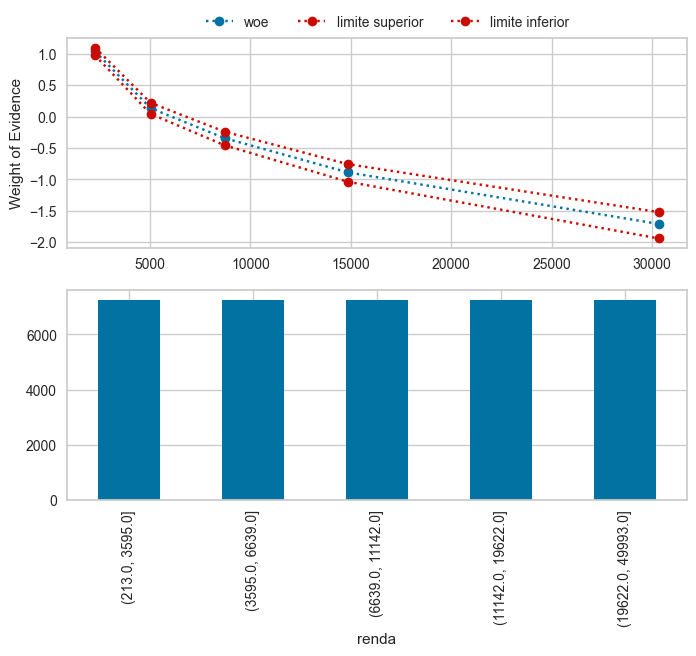

In [196]:
biv_continua(continuas[4], 5, df);

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [197]:
df2['tempo_emprego'] = df2['tempo_emprego'].fillna(df2['tempo_emprego'].mean())

In [198]:
metadados.sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV
tipo_renda,object,0.0,5.0,covariavel,inf
renda,float64,0.0,33319.0,covariavel,0.962816
tempo_emprego,float64,6794.0,2942.0,covariavel,0.390891
idade,int64,0.0,47.0,covariavel,0.014767
tipo_residencia,object,0.0,6.0,covariavel,0.012035
posse_de_imovel,object,0.0,2.0,covariavel,0.008643
educacao,object,0.0,5.0,covariavel,0.005671
estado_civil,object,0.0,5.0,covariavel,0.004123
qt_pessoas_residencia,float64,0.0,9.0,covariavel,0.001218
sexo,object,0.0,2.0,covariavel,0.000115


In [199]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
df2['tempo_emprego_norm'] = sc_X.fit_transform(df2[['tempo_emprego']])
df2['renda_norm'] = sc_X.fit_transform(df2[['renda']])
df_oot2['tempo_emprego_norm'] = sc_X.fit_transform(df_oot2[['tempo_emprego']])
df_oot2['renda_norm'] = sc_X.fit_transform(df_oot2[['renda']])

formula = 'mau ~ sexo + tipo_renda + tempo_emprego_norm + renda_norm'

rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:                36206
Model:                            GLM   Df Residuals:                    36199
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8037.3
Date:                Wed, 27 Dec 2023   Deviance:                       16075.
Time:                        17:53:55   Pearson chi2:                 5.90e+04
No. Iterations:                     8   Pseudo R-squ. (CS):            0.04111
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -3.1417      0.047    -67.093      0.000      -3.233      -3.050
sexo[T.M]                          0.0108      0.047      0.228      0.820      -0.082       0.103
tipo_renda[T.Empresário]          -0.1053      0.055     -1.911      0.056      -0.213       0.003
tipo_renda[T.Pensionista]         -0.0624      0.061     -1.026      0.305      -0.182       0.057
tipo_renda[T.Servidor público]    -0.1827      0.094     -1.938      0.053      -0.367       0.002
tempo_emprego_norm                -0.0936      0.031     -3.012      0.003      -0.154      -0.033
renda_norm                        -1.3646      0.052    -26.268      0.000      -1.466      -1.263
==================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [200]:
from sklearn import metrics
from scipy.stats import ks_2samp

y_pred = rl.predict(df2[['sexo', 'tipo_renda', 'tempo_emprego_norm', 'renda_norm']])
y_test = df2.mau

previsao = pd.DataFrame()
previsao['teste'] = y_test
previsao['predito'] = y_pred

previsao = previsao[previsao.predito.notna()]
previsao.isna().sum()

acc = metrics.accuracy_score(y_test, y_pred>0.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(previsao['teste'], previsao['predito'])
auc_ = metrics.auc(fpr, tpr)
# #Gini
gini = 2*auc_ -1
# #KS
ks = ks_2samp(previsao.loc[y_test == 1, 'predito'], previsao.loc[y_test != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 93.41%
KS: 36.74% 
AUC: 74.36% 
GINI: 48.72%


In [201]:
from sklearn import metrics
from scipy.stats import ks_2samp

y_pred = rl.predict(df_oot2[['sexo', 'tipo_renda', 'tempo_emprego_norm', 'renda_norm']])
y_test = df_oot2.mau

previsao = pd.DataFrame()
previsao['teste'] = y_test
previsao['predito'] = y_pred

previsao = previsao[previsao.predito.notna()]
previsao.isna().sum()

acc = metrics.accuracy_score(y_test, y_pred>0.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(previsao['teste'], previsao['predito'])
auc_ = metrics.auc(fpr, tpr)
# #Gini
gini = 2*auc_ -1
# #KS
ks = ks_2samp(previsao.loc[y_test == 1, 'predito'], previsao.loc[y_test != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 85.32%
KS: 35.88% 
AUC: 74.12% 
GINI: 48.23%


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [208]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

imputer = SimpleImputer(strategy='mean')


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [203]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.covariance import EllipticEnvelope

class EllipticEnvelopeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, contamination=0.1):
        self.contamination = contamination
        self.envelope = EllipticEnvelope(contamination=self.contamination, support_fraction=0.9)

    def fit(self, X, y=None):
        self.envelope.fit(X)
        return self

    def transform(self, X, y=None):
        return self.envelope.predict(X).reshape(-1, 1)

outliers_removal = EllipticEnvelopeTransformer(contamination=0.1)

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [204]:
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [205]:
pca_pipe = PCA(n_components=5)

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [206]:
dummies = OneHotEncoder(handle_unknown='ignore')

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [210]:
numeric_features = continuas
categorical_features = discretas[:-1]


numeric_transformer = Pipeline(steps=[
    ('imputer', imputer),
    ('outliere_removal', outliers_removal),   
])


categorical_transformer = Pipeline(steps=[
    ('dummy', dummies),
    ('feature_selector', feature_selector),
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('pca', pca_pipe),
                           ('log_reg', LogisticRegression(max_iter=200))
                          ])


pipe.fit(df2[variaveis].iloc[:,:-1], df2['mau'])
pipe

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 keep_empty_features=False,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                                                 verbose='deprecated')),
                                                                  ('outlier...
                     n_oversamples=10, power_iteration_normalizer='auto',
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=200,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [213]:
from sklearn import metrics
from scipy.stats import ks_2samp

y_pred = pipe.predict(df_oot2[variaveis].iloc[:,:-1])
y_test = df_oot2.mau

previsao = pd.DataFrame()
previsao['teste'] = y_test
previsao['predito'] = y_pred

previsao = previsao[previsao.predito.notna()]
previsao.isna().sum()

acc = metrics.accuracy_score(y_test, y_pred>0.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(previsao['teste'], previsao['predito'])
auc_ = metrics.auc(fpr, tpr)
# #Gini
gini = 2*auc_ -1
# #KS
ks = ks_2samp(previsao.loc[y_test == 1, 'predito'], previsao.loc[y_test != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 85.32%
KS: 0.00% 
AUC: 50.00% 
GINI: 0.00%


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [214]:
from pycaret.classification import *
setup = setup(
    data = df2,
    target = 'mau',
    numeric_imputation='mean',
    normalize=True,           
    remove_outliers=True,     
    pca=True,                 
    pca_components=5,
    normalize_method='zscore', 
    transformation=True,
    transformation_method = 'quantile',
    fix_imbalance=True
)
models()

,Description,Value
0,Session id,8474
1,Target,mau
2,Target type,Binary
3,Original data shape,"(36206, 18)"
4,Transformed data shape,"(56066, 6)"
5,Transformed train set shape,"(45204, 6)"
6,Transformed test set shape,"(10862, 6)"
7,Ordinal features,4
8,Numeric features,9
9,Date features,1


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [216]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8765,0.8165,0.5269,0.2733,0.3599,0.2991,0.3189
1,0.8619,0.8109,0.5449,0.2493,0.3421,0.2767,0.3033
2,0.8564,0.8156,0.5150,0.2331,0.3209,0.2532,0.2782
3,0.8694,0.8211,0.5298,0.2610,0.3497,0.2863,0.3086
4,0.8603,0.8286,0.6048,0.2596,0.3633,0.2986,0.3325
5,0.8875,0.7987,0.4850,0.2893,0.3624,0.3050,0.3173
6,0.8702,0.8346,0.5629,0.2686,0.3636,0.3013,0.3270
7,0.8828,0.8440,0.5749,0.2981,0.3926,0.3349,0.3571
8,0.8496,0.8076,0.5509,0.2312,0.3257,0.2566,0.2875


In [239]:
tuned_lightgbm = tune_model(lightgbm, optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8600,0.8245,0.5269,0.2418,0.3315,0.2651,0.2903
1,0.8446,0.8340,0.5389,0.2211,0.3136,0.2429,0.2737
2,0.8529,0.8230,0.5629,0.2386,0.3351,0.2673,0.2987
3,0.8521,0.8056,0.5119,0.2269,0.3144,0.2451,0.2708
4,0.8354,0.8153,0.5868,0.2197,0.3197,0.2476,0.2865
5,0.8650,0.7884,0.4731,0.2372,0.3160,0.2502,0.2686
6,0.8520,0.8322,0.5749,0.2400,0.3386,0.2708,0.3038
7,0.8465,0.8091,0.5449,0.2252,0.3187,0.2487,0.2797
8,0.8394,0.7949,0.5509,0.2170,0.3113,0.2394,0.2730


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


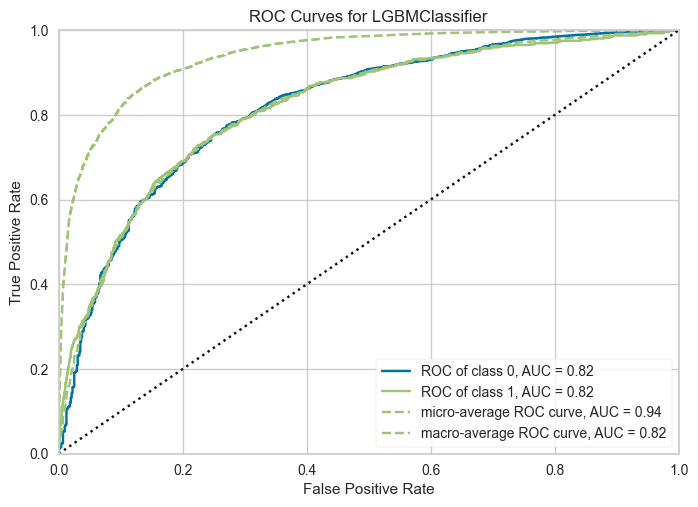

In [240]:
plot_model(tuned_lightgbm, plot = 'auc')

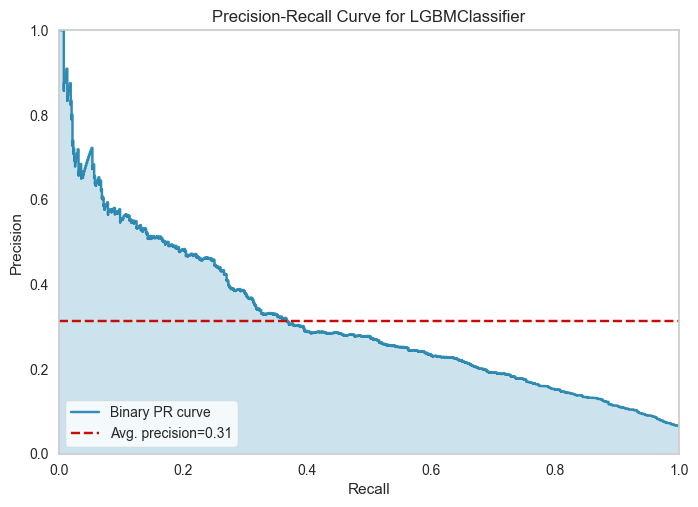

In [241]:
plot_model(tuned_lightgbm, plot = 'pr')

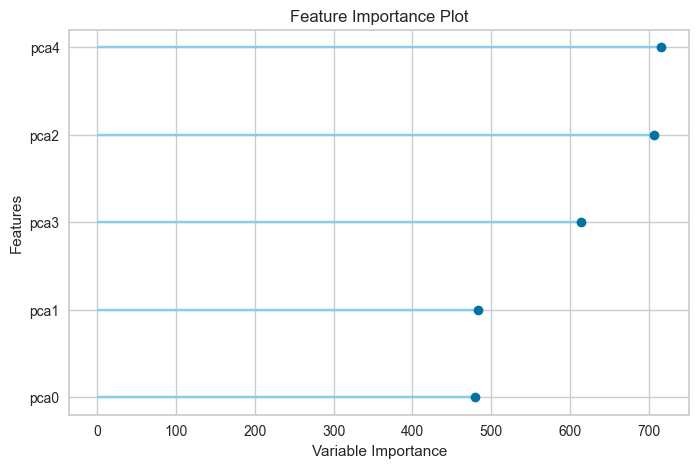

In [242]:
plot_model(tuned_lightgbm, plot = 'feature')

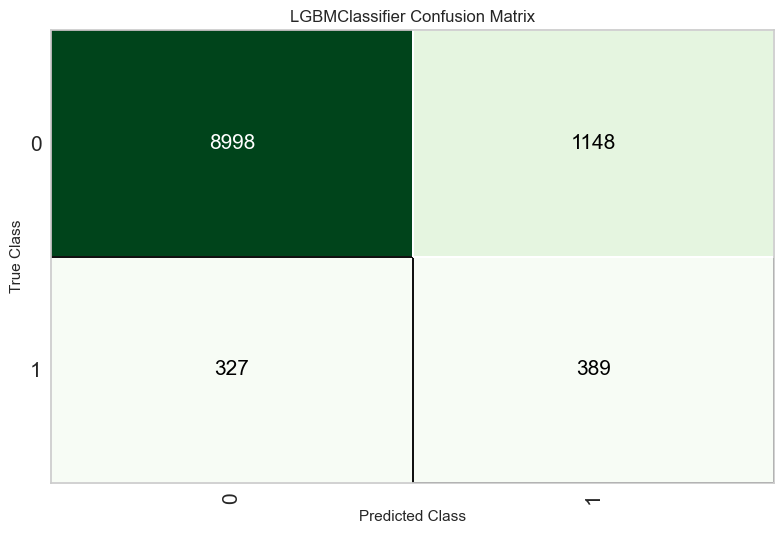

In [243]:
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

In [244]:
predict_model(tuned_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8642,0.8204,0.5433,0.2531,0.3453,0.2806,0.3062


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,bom,tempo_emprego_norm,renda_norm,mau,prediction_label,prediction_score
415096,2015-09-01,9140,M,S,N,1,Empresário,Fundamental/Médio,Casado,Casa,40,2.284931,3.0,6269.149902,1,-0.933155,-0.556357,0,0,0.8471
268481,2015-06-01,9258,F,N,N,0,Empresário,Fundamental/Médio,Casado,Casa,50,4.931507,2.0,5963.419922,1,-0.317949,-0.584881,0,0,0.9465
308903,2015-07-01,4934,M,N,S,1,Assalariado/Bolsista,Superior,Casado,Casa,25,3.383562,3.0,27533.339844,1,-0.677774,1.427538,0,0,0.9668
62539,2015-02-01,14088,F,N,N,0,Assalariado/Bolsista,Fundamental/Médio,Casado,Casa,48,4.709589,2.0,3747.850098,1,-0.369534,-0.791588,0,0,0.8192
575917,2015-12-01,15734,F,N,S,0,Empresário,Fundamental/Médio,Solteiro,Casa,50,6.687671,1.0,4214.479980,1,0.090279,-0.748053,0,0,0.9484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61454,2015-02-01,10512,F,N,S,0,Assalariado/Bolsista,Superior,Solteiro,Casa,58,12.684932,1.0,30587.410156,1,1.484365,1.712475,0,0,0.9931
69713,2015-02-01,11438,F,N,N,0,Pensionista,Fundamental/Médio,Viúvo,Casa,65,6.299299,1.0,6656.850098,1,0.000000,-0.520186,0,0,0.9869
39059,2015-01-01,9050,F,S,S,1,Assalariado/Bolsista,Superior,Casado,Casa,31,6.780822,3.0,4019.330078,1,0.111932,-0.766260,0,1,0.6654
552921,2015-12-01,9977,F,N,S,0,Empresário,Fundamental/Médio,Casado,Casa,47,8.854795,2.0,3095.129883,0,0.594035,-0.852485,1,1,0.6302


In [245]:
final_lightgbm = finalize_model(tuned_lightgbm)
print(final_lightgbm)

Pipeline(memory=Memory(location=None),
         steps=[('date_feature_extractor',
                 TransformerWrapper(exclude=None, include=['data_ref'],
                                    transformer=ExtractDateTimeFeatures(features=['day',
                                                                                  'month',
                                                                                  'year']))),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['index', 'qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda',
                                             'bom', 'tempo_emp...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.

In [246]:
predict_model(final_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8428,0.8345,0.6536,0.2427,0.3540,0.2853,0.3310


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,bom,tempo_emprego_norm,renda_norm,mau,prediction_label,prediction_score
415096,2015-09-01,9140,M,S,N,1,Empresário,Fundamental/Médio,Casado,Casa,40,2.284931,3.0,6269.149902,1,-0.933155,-0.556357,0,0,0.7837
268481,2015-06-01,9258,F,N,N,0,Empresário,Fundamental/Médio,Casado,Casa,50,4.931507,2.0,5963.419922,1,-0.317949,-0.584881,0,0,0.9125
308903,2015-07-01,4934,M,N,S,1,Assalariado/Bolsista,Superior,Casado,Casa,25,3.383562,3.0,27533.339844,1,-0.677774,1.427538,0,0,0.9797
62539,2015-02-01,14088,F,N,N,0,Assalariado/Bolsista,Fundamental/Médio,Casado,Casa,48,4.709589,2.0,3747.850098,1,-0.369534,-0.791588,0,0,0.8121
575917,2015-12-01,15734,F,N,S,0,Empresário,Fundamental/Médio,Solteiro,Casa,50,6.687671,1.0,4214.479980,1,0.090279,-0.748053,0,0,0.9512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61454,2015-02-01,10512,F,N,S,0,Assalariado/Bolsista,Superior,Solteiro,Casa,58,12.684932,1.0,30587.410156,1,1.484365,1.712475,0,0,0.9891
69713,2015-02-01,11438,F,N,N,0,Pensionista,Fundamental/Médio,Viúvo,Casa,65,6.299299,1.0,6656.850098,1,0.000000,-0.520186,0,0,0.9140
39059,2015-01-01,9050,F,S,S,1,Assalariado/Bolsista,Superior,Casado,Casa,31,6.780822,3.0,4019.330078,1,0.111932,-0.766260,0,1,0.6254
552921,2015-12-01,9977,F,N,S,0,Empresário,Fundamental/Médio,Casado,Casa,47,8.854795,2.0,3095.129883,0,0.594035,-0.852485,1,1,0.8339


In [247]:
df_oot2['bom'] = 1-df_oot2.mau
unseen_predictions = predict_model(lightgbm, data=df_oot2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7543,0.7917,0.6676,0.3323,0.4437,0.3081,0.3390


In [248]:
from pycaret.utils.generic import check_metric
check_metric(unseen_predictions['mau'], unseen_predictions['prediction_label'], metric = 'Accuracy')

0.7543

In [249]:
save_model(final_lightgbm,'Final GBC Model 28Dez2023')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['data_ref'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['index', 'qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda',
                                              'bom', 'tempo_emp...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 l